# YOLO Detection workflow

### Extracting ellipse parameters, cleaning data, and generating height vs. width

This notebook performs the following tasks:

- Run YOLO on all images of the stack  
- Check performance of YOLO Detector


In [ ]:
# Imports and environment setup for YOLO dataset creation and image processing

import numpy as np  # Numerical computations
import os  # File and directory operations
from skimage.io import imread  # Image reading
from skimage import transform  # Image resizing and transformations
import matplotlib.pyplot as plt  # Plotting and visualization
import cv2  # OpenCV for image processing
from PIL import Image  # Image handling
from tifffile import imwrite  # TIFF file writing
from pathlib import Path  # Path handling
from skimage.filters import threshold_otsu  # Thresholding
import shutil  # File operations like copy/move
from skimage.measure import regionprops  # Region properties for segmentation
from scipy.spatial import distance  # Distance calculations
import pandas as pd  # Data handling and analysis
import torch  # PyTorch for model handling
import glob  # File pattern matching
from ultralytics import YOLO  # YOLO model
from tqdm import tqdm  # Progress bars for loops

import matplotlib.pyplot as plt  # plotting
import pandas as pd  # data handling
from sklearn.cluster import KMeans  # clustering
import ast  # for parsing strings into Python objects
from scipy.stats import zscore  # for standardization


# Pandas display options for debugging and visualization
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-adjust width
pd.set_option('display.max_colwidth', None)  # Show full column width


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [9]:
model = YOLO("runs/detect/train62/weights/best.pt")

In [ ]:
# This block performs object detection on a stack of TIFF images using a YOLO model.
# Tasks performed:
# - Load all TIFF files from the "final/full_stack" folder
# - Run YOLO predictions on each image
# - Store total detections and bounding boxes in a DataFrame
# - Save raw image arrays for later processin

# # Initialize DataFrame
# df_detect = pd.DataFrame(columns=["image_file", "total_detections", "Bbox"])
# im_list =[]

# # Get list of TIFF files and sort
# tif_files = glob.glob(os.path.join("final/full_stack/", '*.tif'))
# tif_files.sort()

# # Iterate with tqdm progress bar
# for file_path in tqdm(tif_files, desc="Processing images"):
#     results = model.predict(file_path, conf=0.2, verbose=False)
#     im = imread(file_path)
#     im_list.append(im)
#     for r in results:
#         num_detections = len(r.boxes)
        
#         for det in r.boxes:
#             df_row = pd.DataFrame({
#                 "image_file": [file_path],
#                 "total_detections": [num_detections],
#                 "Bbox": [det.xywhn.tolist()[0]]
#             })
#             df_detect = pd.concat([df_detect, df_row], ignore_index=True)

# # Save to CSV
# df_detect.to_csv('df_detect.csv', index=False)
# np.save("im_list_full.npy",im_list)


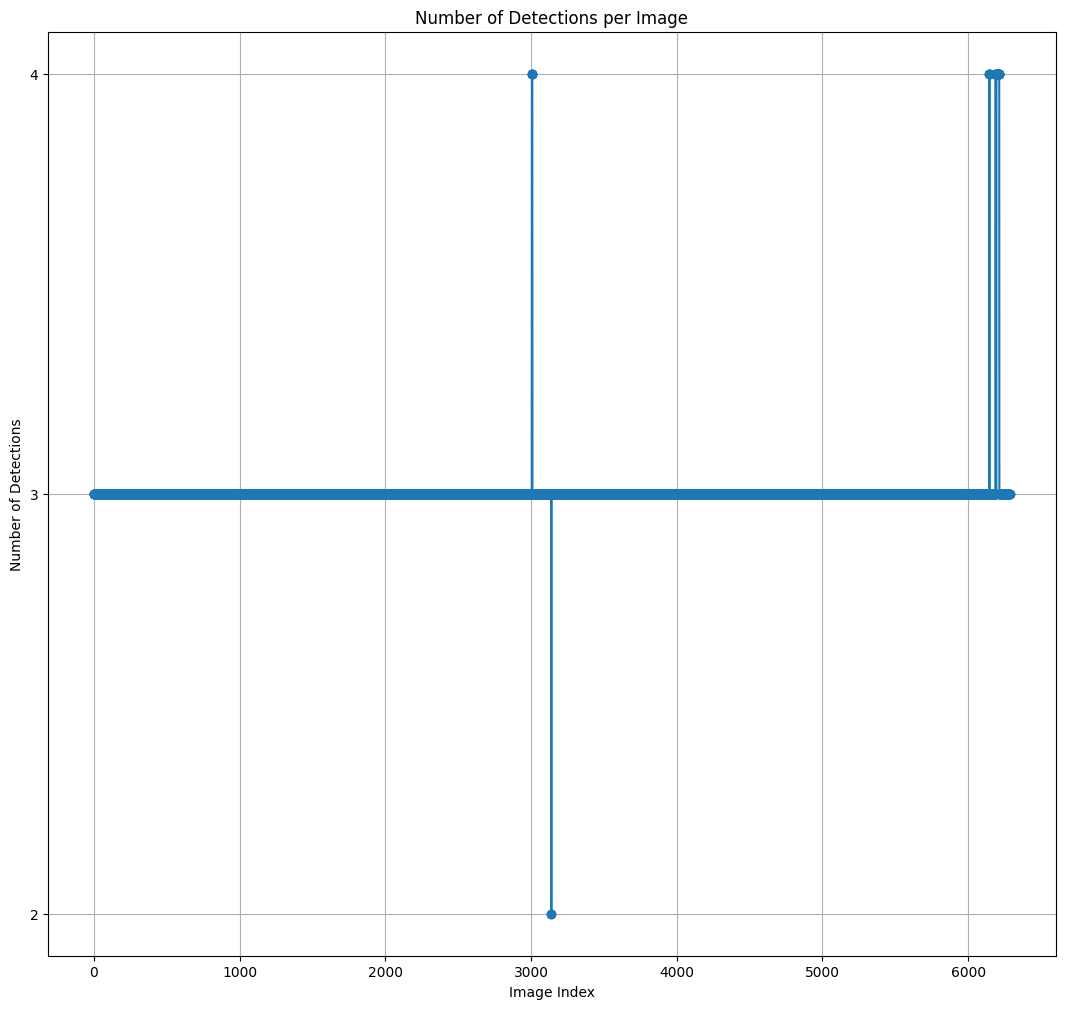

In [3]:


# Read CSV
df_detect = pd.read_csv('df_detect.csv')

# Extract last column and filtered indices
num_cones = df_detect.iloc[:, 1]


# Create Plot
plt.figure(figsize=(13, 12))
plt.plot(num_cones, marker='o', linestyle='-')
plt.title('Number of Detections per Image')
plt.xlabel('Image Index')
plt.ylabel('Number of Detections')
plt.yticks([2, 3, 4])

# Ensure xticks are only multiples of 100 that exist in the index range

plt.grid(True)
plt.show()


In [12]:
im_list = np.load('im_list_full.npy')


Lower Bound: 0.5972668766975403, Upper Bound: 0.7972668766975403
Lower Bound: -0.03982988968491555, Upper Bound: 0.16017011031508446
Lower Bound: 0.26546292901039126, Upper Bound: 0.4654629290103912


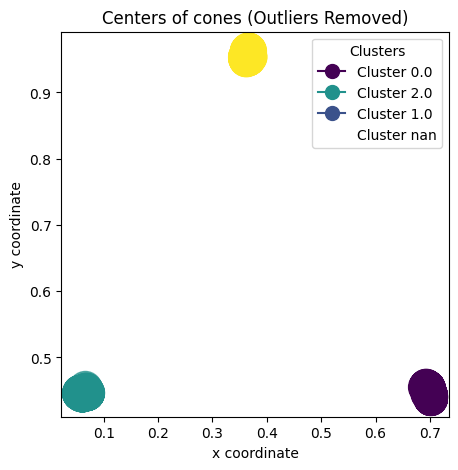

In [ ]:


# This block reads the previously saved detection CSV and plots the
# number of detected cones per image.

def remove_outliers(df, threshold=20):
    # Calculate the median for the column
    median = df["x_center"].median()
    
    # Calculate the lower and upper bounds
    lower_bound = median - threshold
    upper_bound = median + threshold
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

    # Drop rows where the 'x_center' value is outside the bounds
    df_cleaned = df[(df["x_center"] >= lower_bound) & (df["x_center"] <= upper_bound)]
    
    return df_cleaned

# Assuming df_detect is your original dataframe

df = df_detect.copy()
df["Bbox"] = df["Bbox"].apply(ast.literal_eval)

# Extract X-center and Y-center from Bbox
df[["x_center", "y_center", "width", "height"]] = df["Bbox"].apply(lambda b: pd.Series([b[0], b[1], b[2], b[3]]))

# Set a threshold for removing outliers, e.g., 3 standard deviations

df_no_outliers = df.copy()



# Now apply K-Means clustering on the cleaned data (without outliers)
kmeans = KMeans(n_clusters=3, random_state=42)
df_no_outliers["cluster_label"] = kmeans.fit_predict(df_no_outliers[["x_center", "y_center"]])

for i in range(3):
    df_cluster= df_no_outliers[df_no_outliers["cluster_label"] == i]
    df_cluster_cleaned = remove_outliers(df_cluster, threshold=0.1)
    df_no_outliers[df_no_outliers["cluster_label"] == i] = df_cluster_cleaned



# Plotting the centers with clusters (after removing outliers)
plt.figure(figsize=(5, 5))
scatter = plt.scatter(df_no_outliers["x_center"], df_no_outliers["y_center"], s=550, c=df_no_outliers["cluster_label"], cmap='viridis', marker="o", alpha=0.7)

# Adding labels and title
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.title("Centers of cones (Outliers Removed)")

# Dynamically create legend labels from unique cluster labels
import matplotlib.lines as mlines

legend_labels = []
for cluster in df_no_outliers["cluster_label"].unique():  # Loop through unique cluster labels
    cluster_color = plt.cm.viridis(cluster / len(df_no_outliers["cluster_label"].unique()))
    cluster_patch = mlines.Line2D([], [], color=cluster_color, marker='o', markersize=10, label=f'Cluster {cluster}')
    legend_labels.append(cluster_patch)

# Add custom legend
plt.legend(handles=legend_labels, title="Clusters")

# Show plot
plt.show()


In [14]:
df_cluster.head()

,image_file,total_detections,Bbox,x_center,y_center,width,height,cluster_label
1,final/full_stack/final_full_stack0001.tif,3.0,"[0.36499518156051636, 0.9550479650497437, 0.13714833557605743, 0.08990407735109329]",0.364995,0.955048,0.137148,0.089904,2.0
3,final/full_stack/final_full_stack0002.tif,3.0,"[0.3653098940849304, 0.9541527032852173, 0.13958290219306946, 0.09169456362724304]",0.365310,0.954153,0.139583,0.091695,2.0
7,final/full_stack/final_full_stack0003.tif,3.0,"[0.3646625876426697, 0.9535262584686279, 0.14136575162410736, 0.09294751286506653]",0.364663,0.953526,0.141366,0.092948,2.0
10,final/full_stack/final_full_stack0004.tif,3.0,"[0.3663836717605591, 0.9531177282333374, 0.1399383693933487, 0.09376455843448639]",0.366384,0.953118,0.139938,0.093765,2.0
13,final/full_stack/final_full_stack0005.tif,3.0,"[0.36732080578804016, 0.95371413230896, 0.13854674994945526, 0.09257165342569351]",0.367321,0.953714,0.138547,0.092572,2.0
